In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
epoch_key = "Cor", 1, 2

In [3]:
import logging
import os
import sys
from argparse import ArgumentParser
from signal import SIGUSR1, SIGUSR2, signal
from subprocess import PIPE, run

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy.ndimage import label
from tqdm.auto import tqdm

from loren_frank_data_processing import save_xarray
from loren_frank_data_processing.position import (
    EDGE_ORDER,
    EDGE_SPACING,
    make_track_graph,
)
from replay_trajectory_classification import (
    ClusterlessClassifier,
    SortedSpikesClassifier,
)
from src.analysis import (
    get_linear_position_order,
    get_place_field_max,
    get_replay_info,
    reshape_to_segments,
)
from src.load_data import load_data
from src.parameters import (
    ANIMALS,
    FIGURE_DIR,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    knot_spacing,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
    spike_model_penalty,
)
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_neuron_place_field_2D_1D_position,
    plot_ripple_decode_1D,
    plot_ripple_decode_2D,
)

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")

animal, day, epoch = epoch_key
data_type, dim = "clusterless", "1D"

logging.info("Loading data...")
data = load_data(epoch_key)

is_training = data["position_info"].speed > 4
position = data["position_info"].loc[:, "linear_position"]
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

model_name = os.path.join(
    PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl"
)
try:
    results = xr.open_dataset(
        os.path.join(PROCESSED_DATA_DIR, f"{animal}_{day:02}_{epoch:02}.nc"),
        group=f"/{data_type}/{dim}/classifier/ripples/",
    )
    logging.info("Found existing results. Loading...")
    ripple_times = data["ripple_times"].loc[:, ["start_time", "end_time"]]
    spikes = (
        ((data["multiunit"].sum("features") > 0) * 1.0)
        .to_dataframe(name="spikes")
        .unstack()
    )
    spikes.columns = data["tetrode_info"].tetrode_id
    ripple_spikes = reshape_to_segments(spikes, ripple_times)
    classifier = ClusterlessClassifier.load_model(model_name)
    logging.info(classifier)
except (FileNotFoundError, OSError):
    logging.info("Fitting classifier...")
    classifier = ClusterlessClassifier(
        place_bin_size=place_bin_size,
        movement_var=movement_var,
        replay_speed=replay_speed,
        discrete_transition_diag=discrete_diag,
        continuous_transition_types=continuous_transition_types,
        model=model,
        model_kwargs=model_kwargs,
    ).fit(
        position,
        data["multiunit"],
        is_training=is_training,
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )
    classifier.save_model(model_name)
    logging.info(classifier)

    # Decode
    is_test = ~is_training

    test_groups = pd.DataFrame(
        {"test_groups": label(is_test.values)[0]}, index=is_test.index
    )
    immobility_results = []
    for _, df in tqdm(
        test_groups.loc[is_test].groupby("test_groups"), desc="immobility"
    ):
        start_time, end_time = df.iloc[0].name, df.iloc[-1].name
        test_multiunit = data["multiunit"].sel(time=slice(start_time, end_time))
        immobility_results.append(
            classifier.predict(test_multiunit, time=test_multiunit.time)
        )

    immobility_results = xr.concat(immobility_results, dim="time")

    results = [
        (
            immobility_results.sel(
                time=slice(df.start_time, df.end_time)
            ).assign_coords(time=lambda ds: ds.time - ds.time[0])
        )
        for _, df in data["ripple_times"].iterrows()
    ]

    results = xr.concat(results, dim=data["ripple_times"].index).assign_coords(
        state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
    )

    ripple_times = data["ripple_times"].loc[:, ["start_time", "end_time"]]
    spikes = (
        ((data["multiunit"].sum("features") > 0) * 1.0)
        .to_dataframe(name="spikes")
        .unstack()
    )
    spikes.columns = data["tetrode_info"].tetrode_id
    ripple_spikes = reshape_to_segments(spikes, ripple_times)

    logging.info("Saving results...")
    save_xarray(
        PROCESSED_DATA_DIR,
        epoch_key,
        results.drop(["likelihood", "causal_posterior"]),
        group=f"/{data_type}/{dim}/classifier/ripples/",
    )

logging.info("Saving replay_info...")
replay_info = get_replay_info(
    results,
    ripple_spikes,
    data["ripple_times"],
    data["position_info"],
    track_graph,
    SAMPLING_FREQUENCY,
    PROBABILITY_THRESHOLD,
    epoch_key,
    classifier,
)

15-Jun-20 17:04:20 Loading data...
15-Jun-20 17:04:39 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO01.mat
15-Jun-20 17:04:39 No DIO file found, using distance from well to segment trials
15-Jun-20 17:04:39 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO01.mat
15-Jun-20 17:04:39 No DIO file found, inferring correct inbound/outbound from task rules
15-Jun-20 17:04:56 Finding ripple times...
15-Jun-20 17:05:55 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO01.mat
15-Jun-20 17:05:55 No DIO file found, using distance from well to segment trials
15-Jun-20 17:05:55 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Corriander/CorDIO01.mat
15-Jun-20 17:05:55 No DIO file found, inferring correct inbound/outbound from task rules
15-Jun-20 17:06:14 Found existing results. Loading...
15-Jun-20 17:06:14 ClusterlessClassifier(continuous_transiti

In [62]:
ripple_number = 13
s = (
    (
        ~np.isnan(
            data["multiunit"].sel(
                time=slice(
                    data["ripple_times"].loc[ripple_number].start_time,
                    data["ripple_times"].loc[ripple_number].end_time,
                )
            )
        )
    ).sum("features")
    > 0
) * 1.0

s.values.mean() * SAMPLING_FREQUENCY, ripple_spikes.loc[
    ripple_number
].to_numpy().mean() * SAMPLING_FREQUENCY

(72.93868921775898, 72.93868921775898)

In [71]:
s.values.mean(axis=0) * SAMPLING_FREQUENCY

array([ 23.25581395,   0.        ,  93.02325581,  81.39534884,
       104.65116279, 139.53488372,  69.76744186,  34.88372093,
        58.13953488, 116.27906977,  81.39534884])

In [72]:
s.values.sum(axis=0)

array([ 2.,  0.,  8.,  7.,  9., 12.,  6.,  3.,  5., 10.,  7.])

In [77]:
s.values.sum(axis=0) / (s.shape[0] * 2 / 1000)

array([ 23.25581395,   0.        ,  93.02325581,  81.39534884,
       104.65116279, 139.53488372,  69.76744186,  34.88372093,
        58.13953488, 116.27906977,  81.39534884])

Text(0.5, 1.0, '')

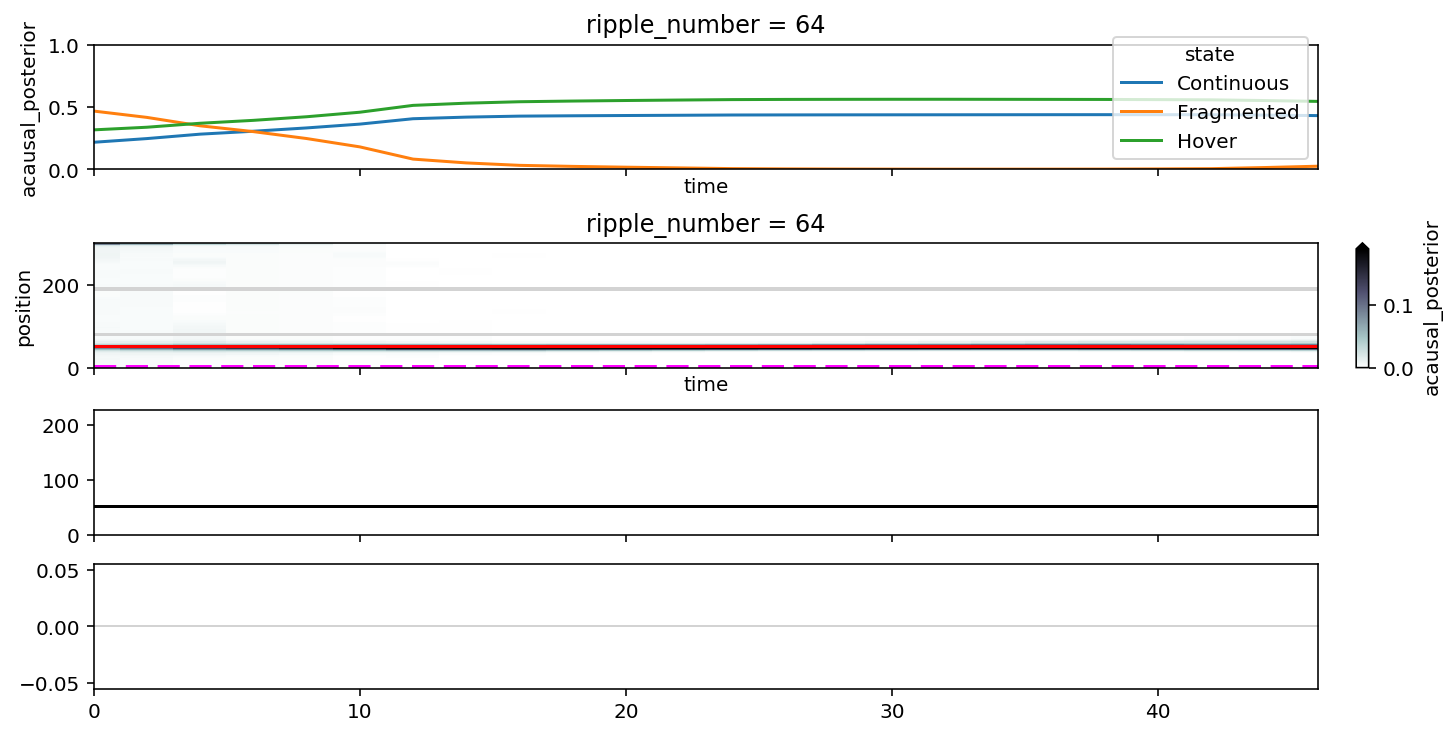

In [198]:
import copy

from src.analysis import maximum_a_posteriori_estimate
from src.analysis import calculate_replay_distance
from loren_frank_data_processing import reshape_to_segments
from scipy.ndimage.filters import gaussian_filter1d

ripple_number = 64

posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: 1000 * ds.time / np.timedelta64(1, "s"))
)


position_info = data["position_info"]
ripple_position_info = reshape_to_segments(position_info, ripple_times)

actual_positions = ripple_position_info.loc[
    ripple_number, ["x_position", "y_position"]
].values
actual_track_segment_ids = (
    ripple_position_info.loc[ripple_number, "track_segment_id"]
    .values.squeeze()
    .astype(int)
)
map_estimate = maximum_a_posteriori_estimate(posterior.sum("state"))

(
    replay_distance_from_actual_position,
    replay_distance_from_center_well,
) = calculate_replay_distance(
    track_graph, map_estimate, actual_positions, actual_track_segment_ids, position_info
)

fig, axes = plt.subplots(4, 1, figsize=(10, 5), sharex=True, constrained_layout=True)
posterior.sum("position").plot(x="time", hue="state", ax=axes[0])
axes[0].set_ylim((0, 1))

cmap = copy.copy(plt.cm.get_cmap("bone_r"))
cmap.set_bad(color="lightgrey", alpha=1.0)
posterior.sum("state", skipna=False).plot(
    x="time", y="position", ax=axes[1], cmap=cmap, robust=True, vmin=0.0
)


axes[1].plot(posterior.time, map_estimate, color="red")
axes[1].plot(
    posterior.time,
    ripple_position_info.loc[ripple_number].linear_position,
    color="magenta",
    linewidth=3,
    linestyle="--",
)

axes[2].plot(posterior.time, replay_distance_from_actual_position)


sigma = 0.001
replay_distance_from_actual_position = gaussian_filter1d(
    replay_distance_from_actual_position, sigma * SAMPLING_FREQUENCY, mode="reflect"
)
axes[2].plot(posterior.time, replay_distance_from_actual_position, color="black")
axes[2].set_ylim((0, 226))

time = posterior.time
replay_speed = np.abs(np.gradient(replay_distance_from_actual_position, time))

axes[3].fill_between(posterior.time, replay_speed, color="lightgrey")
plt.xlim((posterior.time[0], posterior.time[-1]))
axes[3].set_title("")

In [199]:
results

<xarray.Dataset>
Dimensions:            (position: 95, ripple_number: 64, state: 3, time: 76)
Coordinates:
  * state              (state) object 'Continuous' 'Fragmented' 'Hover'
  * position           (position) float64 1.476 4.427 7.379 ... 297.5 300.5
  * time               (time) timedelta64[ns] 00:00:00 ... 00:00:00.150000
  * ripple_number      (ripple_number) int64 1 2 3 4 5 6 7 ... 59 60 61 62 63 64
Data variables:
    acausal_posterior  (ripple_number, time, state, position) float64 0.06879 ... nan

In [ ]:
""